In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import sklearn.model_selection
import models
import util
import os
import config
import viz
import scipy.stats
from tqdm import tqdm
import figs
import matplotlib.image as mpimg
import seaborn as sns

# Look at stylegan-generated images

In [2]:
DIR_ORIG = '../data/annotation-dataset-stylegan2/images'
DIRS_STYLEGAN = '../data_processed/stylegan2'

In [3]:
regs = [0, 0.1, 1, 10000]
IM_NUMS = [0, 1, 10]

In [ ]:
plt.figure(dpi=300)
R, C = len(IM_NUMS), 1 + len(regs)
for r, IM_NUM in enumerate(IM_NUMS):
    ims = []
    latents = []
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{IM_NUM}.jpg'))
    for reg in regs:
        folder = f'generated_images_{reg}'
        im_fname = oj(DIRS_STYLEGAN, folder, f'{IM_NUM}.png')
        ims.append(mpimg.imread(im_fname))
        latents.append(np.load(oj(DIRS_STYLEGAN, folder, f'{IM_NUM}.npy')))
        print(np.mean(np.abs(np.corrcoef(latents[-1]))))

    
    plt.subplot(R, C, C * r + 1)
    util.imshow(im_orig)

    for i in range(len(regs)):
        plt.subplot(R, C, C * r + 2 + i)
        util.imshow(ims[i])

# Look at CELEB-A

In [5]:
DIR_ORIG_CELEBA = '../data/CelebA/Img/img_align_celeba'
DIR_SQUARE_CELEBA = '../data/CelebA/Img/img_square_celeba'

**need to first preprocess celeba to be square before running the pipeline**

In [ ]:
for fname in tqdm(sorted(os.listdir(DIR_ORIG_CELEBA))):
    if '.jpg' in fname:
        im = mpimg.imread(oj(DIR_ORIG_CELEBA, fname))
        if not im.shape[0] == im.shape[1]:
            im = im[20:-20]
        plt.imsave(oj(DIR_SQUARE_CELEBA, fname), im)

# look at celeba-hq

In [2]:
DIR_ORIG = '../data/celeba-hq/ims/'
DIRS_GEN = '../data_processed/celeba-hq/'
regs = [0, 0.1, 1, 10000]
IM_NUMS = np.arange(1, 3)

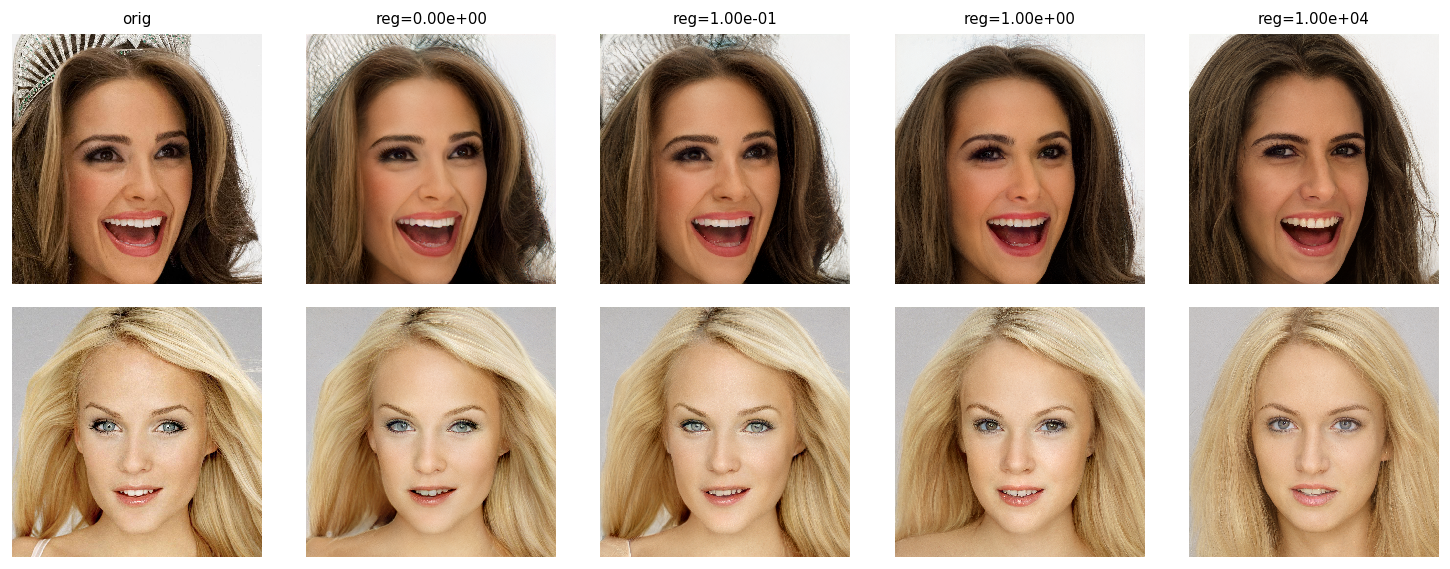

In [3]:
R, C = len(IM_NUMS), 1 + len(regs)
plt.figure(dpi=120, figsize=(C*2.5, R*2.5))
for r, IM_NUM in enumerate(IM_NUMS):
    ims = []
    latents = []
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{IM_NUM:05}.jpg'))
    for reg in regs:
        folder = f'generated_images_{reg}'
        im_fname = oj(DIRS_GEN, folder, f'{IM_NUM:05}.png')
        ims.append(mpimg.imread(im_fname))
        latents.append(np.load(oj(DIRS_GEN, folder, f'{IM_NUM:05}.npy')))
        # print(np.mean(np.abs(np.corrcoef(latents[-1]))))

    
    plt.subplot(R, C, C * r + 1)
    util.imshow(im_orig)
    if r == 0:
        plt.title('orig', fontsize=9)

    for i in range(len(regs)):
        plt.subplot(R, C, C * r + 2 + i)
        util.imshow(ims[i])
        if r == 0:
            plt.title(f'reg={regs[i]:.2e}', fontsize=9)
    latents = np.array(latents)
plt.tight_layout()

## quantitative eval

In [ ]:
# !python process_latents.py

In [72]:
from process_latents import attr_map, ks, load_labs
labs = load_labs()

df = pd.read_pickle('processed/09_df_100.pkl')
df = df[[k for k in df.keys() if not 'lab' in k]]

In [73]:
celeba_labs_fname='../data/celeba-hq/Anno/list_attr_celeba.txt'
remap = pd.read_csv('../data/celeba-hq/mapping.txt', delim_whitespace=True)
labs_full = pd.read_csv(celeba_labs_fname, delim_whitespace=True, skiprows=1)
labs_full = labs_full.loc[[remap.iloc[i]['orig_file'] for i in range(df.shape[0])]] #for i in range(labs_full.shape[0])]
labs = pd.DataFrame()
# print(labs.keys())
# print(labs_full.keys())

# large is more male
labs['gender'] = labs_full['Male']

# larger is longer
labs['hair-length'] = -1 * labs_full['Bald'] # Bangs, Receding_Hairline

# larger is more
labs['facial-hair'] = labs_full['Mustache'] # Goatee, Mustache, No_Beard, 5_o_Clock_Shadow

# higher is more
labs['makeup'] = labs_full['Heavy_Makeup'] # Wearing_Lipstick

# higher is darker
labs['skin-color'] = labs_full['Pale_Skin'] * -1

# older is more positive
labs['age'] = labs_full['Young'] * -1



In [77]:
labs.head()
print(labs.shape)

(392, 6)


In [84]:
print(df.shape)
df.head()


(392, 16)


,perceptual_loss,mean_abs_corr,im_num,reg_param,pred_A,pred_B,pred_C,pred_G,pred_H,pred_M,gender,hair-length,facial-hair,makeup,skin-color,age
0,0.687761,0.183538,1,0.0,0.016675,13.583931,-0.119361,-2.741306,0.180868,-5.712526,-1,1,-1,1,1,-1
1,0.690951,0.646994,1,0.1,-0.011592,1.809329,-0.487955,-1.991345,0.420542,3.807902,-1,1,-1,1,1,-1
2,0.699914,0.986089,1,1.0,-0.018583,2.734919,-0.184379,-3.602747,0.470252,7.793414,-1,1,-1,-1,1,-1
3,0.722005,1.000000,1,10000.0,-0.324412,5.551168,-0.349753,-2.777806,0.416608,1.625070,-1,1,-1,1,1,-1
4,0.741083,0.205875,2,0.0,-0.657519,13.965330,-1.123549,-1.943765,0.177794,-3.489753,-1,1,-1,-1,1,-1


In [68]:
df.append(labs, ignore_index=True).head()

,perceptual_loss,mean_abs_corr,im_num,reg_param,pred_A,pred_B,pred_C,pred_G,pred_H,pred_M,gender,hair-length,facial-hair,makeup,skin-color,age
0,0.687761,0.183538,1.0,0.0,0.016675,13.583931,-0.119361,-2.741306,0.180868,-5.712526,NaN,NaN,NaN,NaN,NaN,NaN
1,0.690951,0.646994,1.0,0.1,-0.011592,1.809329,-0.487955,-1.991345,0.420542,3.807902,NaN,NaN,NaN,NaN,NaN,NaN
2,0.699914,0.986089,1.0,1.0,-0.018583,2.734919,-0.184379,-3.602747,0.470252,7.793414,NaN,NaN,NaN,NaN,NaN,NaN
3,0.722005,1.000000,1.0,10000.0,-0.324412,5.551168,-0.349753,-2.777806,0.416608,1.625070,NaN,NaN,NaN,NaN,NaN,NaN
4,0.741083,0.205875,2.0,0.0,-0.657519,13.965330,-1.123549,-1.943765,0.177794,-3.489753,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
for k in labs.keys():
    df[k] = labs[k].values
# df2 = pd.concat([df, labs])

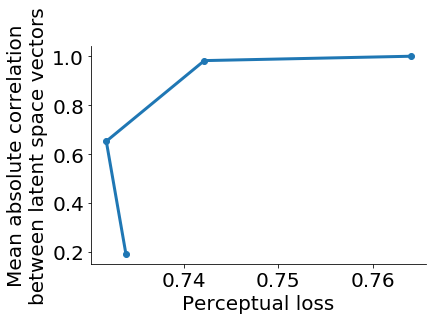

In [81]:
means = df.groupby('reg_param').mean().reset_index()
plt.plot(means['perceptual_loss'], means['mean_abs_corr'], 'o-')
plt.xlabel('Perceptual loss')
plt.ylabel('Mean absolute correlation\nbetween latent space vectors')
plt.show()

In [39]:
df

,perceptual_loss,mean_abs_corr,im_num,reg_param,pred_A,pred_B,pred_C,pred_G,pred_H,pred_M,lab_A,lab_B,lab_C,lab_G,lab_H,lab_M
0,0.687761,0.183538,1,0.0,0.016675,13.583931,-0.119361,-2.741306,0.180868,-5.712526,-1,-1,1,1,1,-1
1,0.690951,0.646994,1,0.1,-0.011592,1.809329,-0.487955,-1.991345,0.420542,3.807902,-1,-1,1,1,1,-1
2,0.699914,0.986089,1,1.0,-0.018583,2.734919,-0.184379,-3.602747,0.470252,7.793414,-1,-1,1,1,1,-1
3,0.722005,1.000000,1,10000.0,-0.324412,5.551168,-0.349753,-2.777806,0.416608,1.625070,-1,-1,1,1,1,-1
4,0.741083,0.205875,2,0.0,-0.657519,13.965330,-1.123549,-1.943765,0.177794,-3.489753,-1,-1,1,-1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,0.821014,1.000000,97,10000.0,0.417458,0.965093,-0.241364,0.506706,-0.217849,-3.853611,-1,-1,1,-1,1,1
388,0.814942,0.186435,98,0.0,0.103679,10.731384,-0.343929,0.389746,-0.302900,-10.646796,-1,-1,1,-1,1,1
389,0.815421,0.660109,98,0.1,0.125312,1.766862,-0.385375,1.119375,-0.266782,-4.343365,-1,-1,1,-1,1,1
390,0.824542,0.981467,98,1.0,0.315448,0.777303,-0.882809,1.394598,-0.418660,-7.088722,-1,-1,1,-1,1,1


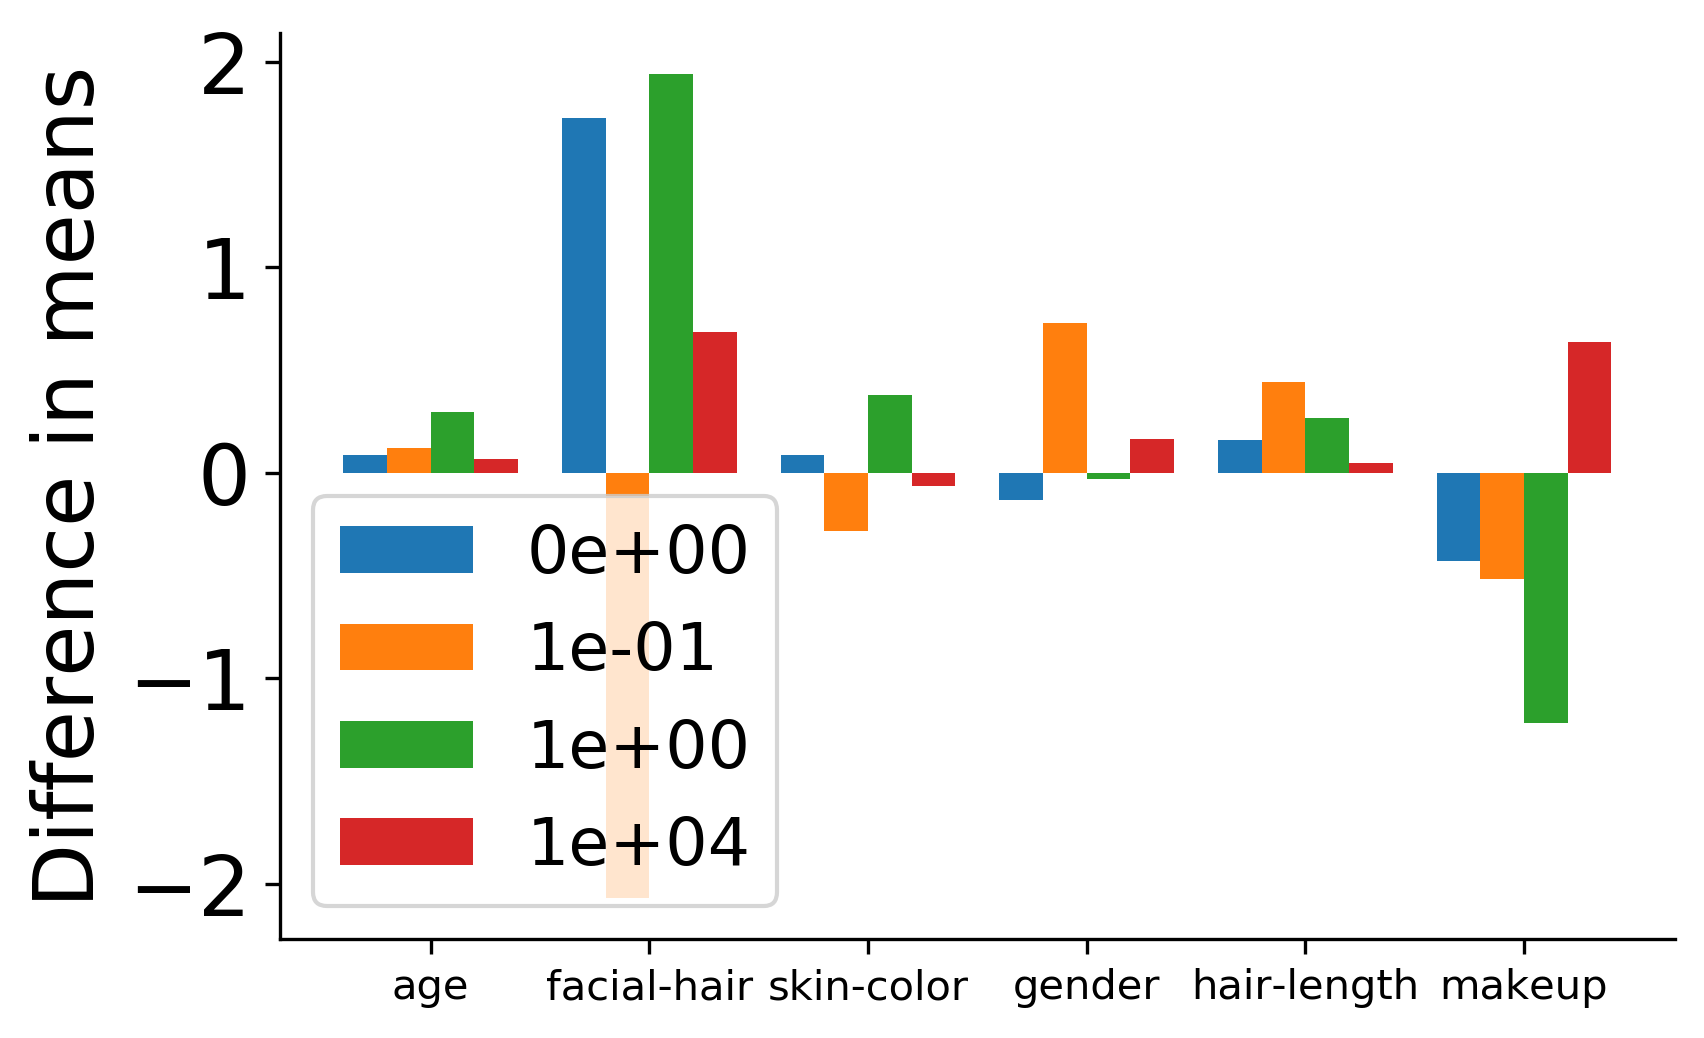

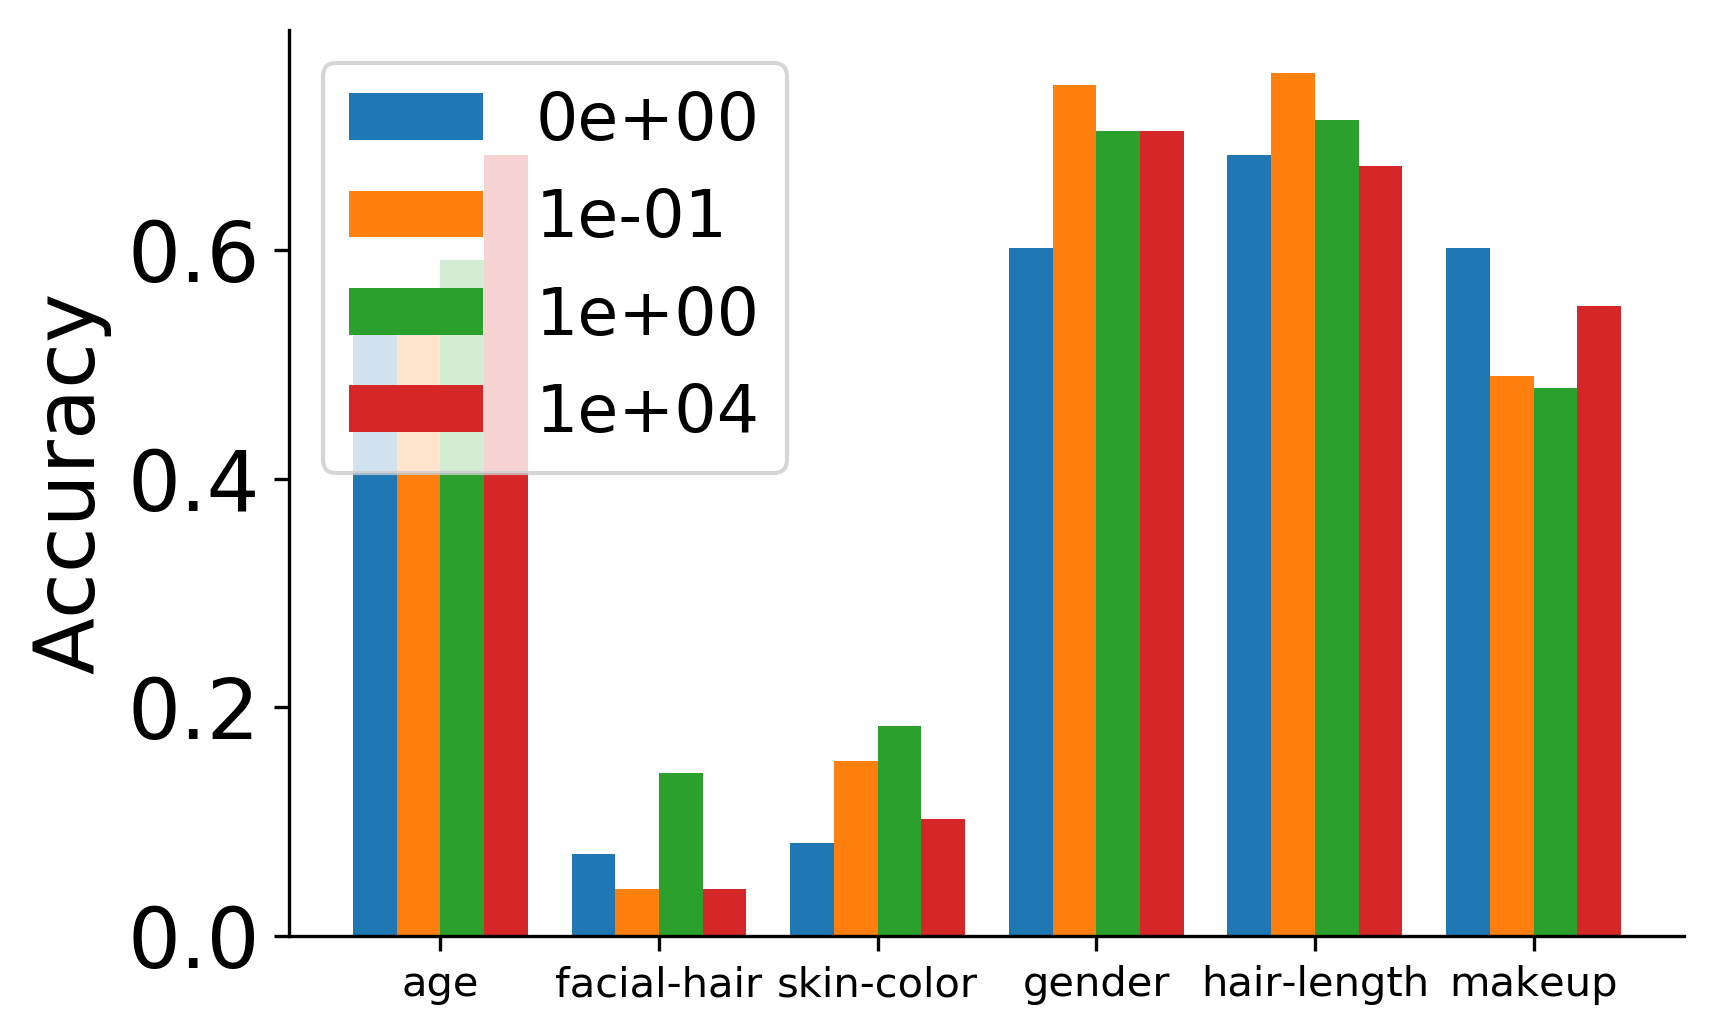

In [86]:
reg_params = df.reg_param.unique()
accs = np.zeros((len(reg_params), len(ks)))
mean_diffs = np.zeros((len(reg_params), len(ks)))
for i, k in enumerate(ks):
    predk = f'pred_{k}'
    # labk = f'lab_{k}'
    labk = f'{attr_map[k]}'
    for j, reg_param in enumerate(reg_params):
#     sns.lmplot(predk, labk, df, hue='reg_param')
        d = df[df.reg_param == reg_param]
#         accs[j, i] = np.mean((d[predk] > 0) == (d[labk] > 0))
#         mean_diffs[j, i] = np.mean(d[predk][d[labk] == 1]) - np.mean(d[predk][d[labk] == -1])
        
        accs[j, i] = np.mean((d[predk] > 0) == (d[labk] > 0))
        mean_diffs[j, i] = np.mean(d[predk][d[labk] == 1]) - np.mean(d[predk][d[labk] == -1])

        
def plot_bars(vals, ylab='Accuracy'):
    fig, ax = plt.subplots(dpi=300)
    ind = np.arange(len(ks)) # the x locations for the groups
    ps = []
    for i in range(len(reg_params)):
        width = 0.2
        val = vals[i, :].flatten()
        ps.append(ax.bar(ind + width * i, val, width))
    plt.xticks(ind + width * 1.5, [attr_map[a] for a in ks], fontsize=10)
    plt.ylabel(ylab)
    ax.legend(ps, [f'{reg:.0e}' for reg in reg_params])
    plt.show()
plot_bars(mean_diffs, 'Difference in means')
plot_bars(accs, 'Accuracy')

In [ ]:
R, C = 2, 3
for i, k in enumerate(ks):
    predk = f'pred_{k}'
    labk = f'lab_{k}'
    sns.lmplot(predk, labk, df, hue='reg_param')
    plt.show()

In [ ]:
# plt.plot(df['perceptual_loss'], df['mean_abs_corr'], '.')
# d = df[df['im_num'] == 2]
d = df
sns.lmplot('perceptual_loss', 'mean_abs_corr', d, hue='reg_param')
plt.show()